# Locality Comparison: Answer vs CoT Intervention Sites

**Note:** This notebook is a placeholder for future experiments comparing different intervention localities.

## Overview

This notebook will compare interventions applied at different token locations:
- **CoT Locality**: Intervention applied during chain-of-thought generation tokens
- **Answer Locality**: Intervention applied only during answer token generation
- **Full Locality**: Intervention applied to all tokens

## Key Questions

1. Does CoT locality intervention affect reasoning quality differently than answer locality?
2. Which locality produces more robust improvements?
3. Are there interactions between locality and layer?
4. Does locality affect specificity (add vs random)?

## 1. Setup and Data Loading

In [1]:
import sys
sys.path.insert(0, '../..')

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# Import evaluation modules
from evaluation import load_data, metrics, plots, statistical_tests

# Set up plotting
plots.setup_style()

# Output directory for figures
OUTPUT_DIR = Path('../outputs/locality_comparison')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print('Setup complete!')

Setup complete!


In [2]:
# Load data - adjust path when you have multiple locality experiments
# This assumes results are organized by locality in directory names
RESULTS_DIR = Path('../../vm_results')

# Load all runs
df = load_data.load_all_runs(RESULTS_DIR)

# Check available localities
if 'locality' in df.columns:
    localities = df['locality'].unique()
    print(f"Available localities: {localities}")
    for loc in localities:
        loc_df = df[df['locality'] == loc]
        print(f"  {loc}: {len(loc_df)} rows")
else:
    print("Warning: No locality column found in data")
    print("This notebook requires data from multiple locality experiments")

Available localities: ['answer' 'cot']
  answer: 600 rows
  cot: 600 rows


## 2. Locality Comparison

Compare intervention effects across localities.

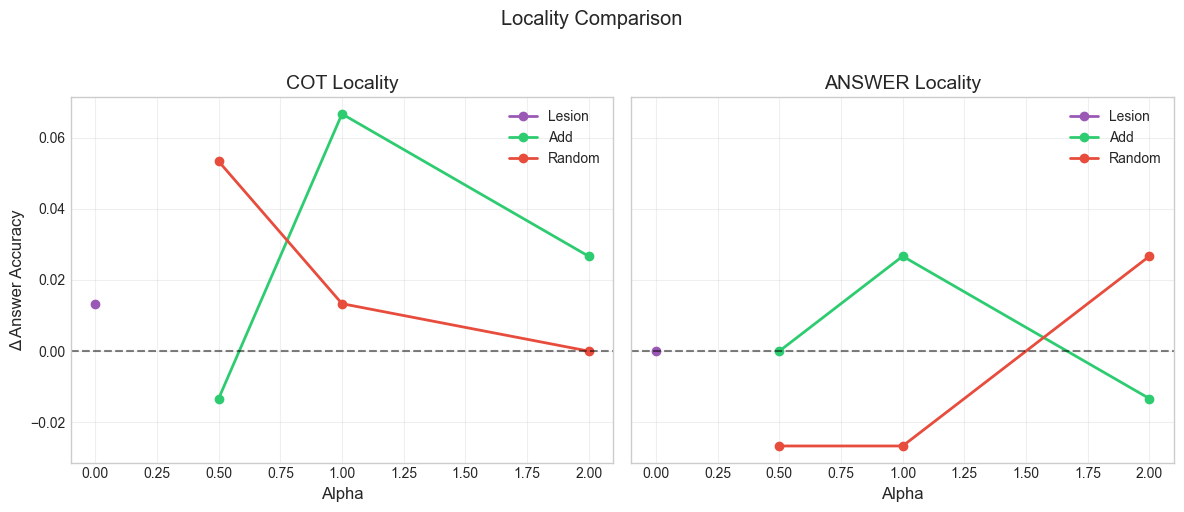

In [3]:
# This section will be populated when answer locality experiments are available

if 'locality' in df.columns and len(df['locality'].unique()) > 1:
    # Plot comparison
    localities_to_compare = ['cot', 'answer']
    available = [loc for loc in localities_to_compare if loc in df['locality'].values]
    
    if len(available) >= 2:
        fig, axes = plots.plot_locality_comparison(
            df, 
            localities=available,
            metric='answer',
            save_path=OUTPUT_DIR / 'locality_comparison.pdf'
        )
        plt.show()
    else:
        print(f"Only found localities: {available}")
        print("Need at least 2 localities to compare")
else:
    print("Waiting for experiments with multiple localities...")
    print("\nTo run this analysis:")
    print("1. Run Phase B with --locality cot")
    print("2. Run Phase B with --locality answer")
    print("3. Re-run this notebook")

## 3. Direct Comparison Table

Compare delta accuracy between localities.

In [4]:
if 'locality' in df.columns and len(df['locality'].unique()) > 1:
    # Use metrics comparison function
    comparison_df = metrics.compare_localities(df, 'cot', 'answer', 'answer')
    
    if len(comparison_df) > 0:
        print("Locality Comparison (CoT vs Answer):")
        display(comparison_df)
    else:
        print("Could not generate comparison")
else:
    print("[Placeholder for comparison table]")

Locality Comparison (CoT vs Answer):


,mode,alpha,layer,cot_delta,answer_delta,difference,cot_n,answer_n
0,add,0.5,25,0.00,0.04,-0.04,25,25
1,add,0.5,26,0.00,0.00,0.00,25,25
2,add,0.5,27,-0.04,-0.04,0.00,25,25
3,add,1.0,25,0.08,0.00,0.08,25,25
4,add,1.0,26,0.08,0.04,0.04,25,25
5,add,1.0,27,0.04,0.04,0.00,25,25
6,add,2.0,25,0.12,0.00,0.12,25,25
7,add,2.0,26,-0.04,0.00,-0.04,25,25
8,add,2.0,27,0.00,-0.04,0.04,25,25
9,lesion,0.0,25,0.00,-0.08,0.08,25,25


## 4. Statistical Tests for Locality Differences

In [5]:
if 'locality' in df.columns and len(df['locality'].unique()) > 1:
    # Run t-test comparing localities
    from scipy.stats import ttest_ind
    
    cot_df = df[df['locality'] == 'cot']
    answer_df = df[df['locality'] == 'answer']
    
    if len(cot_df) > 0 and len(answer_df) > 0:
        # Compute deltas
        def compute_deltas(sub_df):
            base_col = 'baseline_answer_correct'
            intv_col = 'intv_answer_correct'
            if base_col not in sub_df.columns:
                return None
            sub_df = sub_df.copy()
            for col in [base_col, intv_col]:
                if sub_df[col].dtype == object:
                    sub_df[col] = sub_df[col].map({'True': 1, 'False': 0, True: 1, False: 0})
            return (sub_df[intv_col].astype(int) - sub_df[base_col].astype(int)).dropna()
        
        cot_deltas = compute_deltas(cot_df)
        answer_deltas = compute_deltas(answer_df)
        
        if cot_deltas is not None and answer_deltas is not None:
            t_stat, p_value = ttest_ind(cot_deltas, answer_deltas)
            
            print("T-Test: CoT vs Answer Locality")
            print(f"  CoT mean delta: {cot_deltas.mean():.4f}")
            print(f"  Answer mean delta: {answer_deltas.mean():.4f}")
            print(f"  t-statistic: {t_stat:.4f}")
            print(f"  p-value: {p_value:.4f}")
            print(f"  Significant at α=0.05: {p_value < 0.05}")
else:
    print("[Placeholder for statistical tests]")

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

## 5. Locality × Layer Interaction

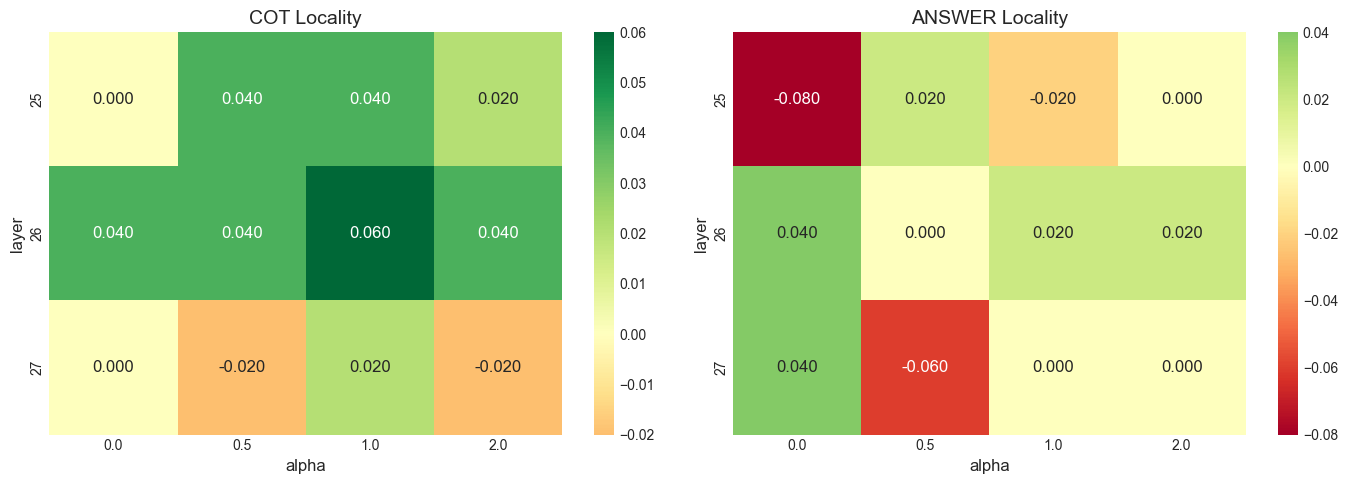

In [6]:
if 'locality' in df.columns and 'layer' in df.columns and len(df['locality'].unique()) > 1:
    # Create heatmap of locality × layer
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for ax, locality in zip(axes, ['cot', 'answer']):
        loc_df = df[df['locality'] == locality]
        if len(loc_df) > 0:
            agg = metrics.aggregate_by_config(loc_df, ['layer', 'alpha'], 'answer')
            if len(agg) > 0:
                pivot = agg.pivot(index='layer', columns='alpha', values='delta')
                sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn', center=0, ax=ax)
                ax.set_title(f'{locality.upper()} Locality')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'locality_layer_interaction.pdf', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("[Placeholder for locality × layer interaction analysis]")

## 6. Summary

### Placeholder Conclusions

When both CoT and Answer locality experiments are available:

1. **Overall comparison**: Which locality produces larger effects?
2. **Consistency**: Which locality is more consistent across alphas/layers?
3. **Specificity**: Does locality affect whether add > random?
4. **Recommendations**: Which locality should be used for future experiments?

In [7]:
print("\n" + "="*60)
print("LOCALITY COMPARISON NOTEBOOK STATUS")
print("="*60)

if 'locality' in df.columns:
    localities = df['locality'].unique().tolist()
    print(f"\nLocalities in current data: {localities}")
    
    if len(localities) > 1:
        print("\n✓ Multiple localities available - full analysis possible")
    else:
        print(f"\n⚠ Only {localities[0]} locality available")
        print("  To complete this analysis, run experiments with:")
        print("    --locality answer")
else:
    print("\n⚠ No locality information in data")
    print("  This may indicate the data was collected with a single locality")


LOCALITY COMPARISON NOTEBOOK STATUS

Localities in current data: ['answer', 'cot']

✓ Multiple localities available - full analysis possible
